In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/04/train_april.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/04/test_april.csv')

In [3]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# Chuẩn hóa

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn feature

In [5]:
top_features =  ['CAPE', 'KX', 'R500', 'R850', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B10B', 'B11B', 'B14B', 'I2B', 'I4B', 'IRB', 'WVB']

In [6]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [7]:
models_info = [
    ("Tháng 4", X_train_scaled, y_train, X_test_scaled, y_test),
]

# Hàm bổ trợ

In [8]:
# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

In [9]:
def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

In [10]:
def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

In [11]:
def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

In [12]:
def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad


In [13]:
param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

In [14]:
def train_and_evaluate_model(name, X_trval, y_trval, X_test, y_test, top_features=None, param_grid=param_grid):
    print(f"\n=== Dataset: {name} ===")

    if top_features is not None:
        X_trval = X_trval[top_features]
        X_test = X_test[top_features]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )

    # One-hot encode
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
    Y_val_oh   = encoder.transform(y_val.to_numpy().reshape(-1, 1))

    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        param_size = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)

        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val @ W1.T + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val @ W2.T + b2
        A2_val = softmax(Z2_val)

        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h

    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    # retrain on full train+val
    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))

    param_size = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, _ = trainscg(lg_full, init_p_full, epochs=8)

    # evaluate
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test @ W1f.T + b1f)
    probs_test = softmax(A1_test @ W2f.T + b2f)
    preds_test = np.argmax(probs_test, axis=1)

    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()



=== Dataset: Tháng 4 (All Features) ===
 hidden_dim=10  → val loss = 0.697775
 hidden_dim=20  → val loss = 0.705335
 hidden_dim=50  → val loss = 0.688052
 hidden_dim=100 → val loss = 0.687476
 hidden_dim=150 → val loss = 0.690362
 hidden_dim=17  → val loss = 0.688222
 hidden_dim=25  → val loss = 0.687511
 hidden_dim=34  → val loss = 0.687286
 hidden_dim=50  → val loss = 0.695260
 hidden_dim=68  → val loss = 0.696111
 hidden_dim=85  → val loss = 0.700963
⇒ Best hidden_dim = 34, validation loss = 0.687286
Test classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     50316
           1       0.05      0.08      0.06      5599

    accuracy                           0.76     55915
   macro avg       0.47      0.46      0.46     55915
weighted avg       0.81      0.76      0.78     55915

Test confusion matrix:
 [[42004  8312]
 [ 5159   440]]


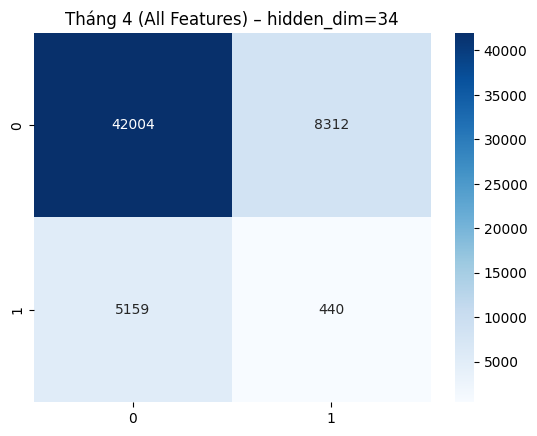


=== Dataset: Tháng 4 (Top Features) ===
 hidden_dim=10  → val loss = 0.691232
 hidden_dim=20  → val loss = 0.693233
 hidden_dim=50  → val loss = 0.691716
 hidden_dim=100 → val loss = 0.691694
 hidden_dim=150 → val loss = 0.691374
 hidden_dim=17  → val loss = 0.680222
 hidden_dim=25  → val loss = 0.689629
 hidden_dim=34  → val loss = 0.696347
 hidden_dim=50  → val loss = 0.697023
 hidden_dim=68  → val loss = 0.696262
 hidden_dim=85  → val loss = 0.693993
⇒ Best hidden_dim = 17, validation loss = 0.680222
Test classification report:
              precision    recall  f1-score   support

           0       0.82      0.36      0.50     50316
           1       0.04      0.27      0.08      5599

    accuracy                           0.35     55915
   macro avg       0.43      0.31      0.29     55915
weighted avg       0.74      0.35      0.46     55915

Test confusion matrix:
 [[18283 32033]
 [ 4109  1490]]


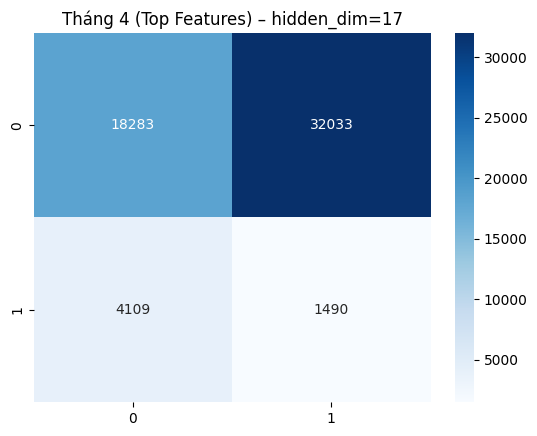

In [15]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

# Oversampling

##  SMOTE

In [16]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [17]:
models_info = [
    ("Tháng 4 smote", X_train_scaled, y_sm, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 smote (All Features) ===
 hidden_dim=10  → val loss = 0.693530
 hidden_dim=20  → val loss = 0.694118
 hidden_dim=50  → val loss = 0.694689
 hidden_dim=100 → val loss = 0.693446
 hidden_dim=150 → val loss = 0.693986


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=17  → val loss = 7.770695
 hidden_dim=25  → val loss = 7.794791
 hidden_dim=34  → val loss = 0.693543


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=50  → val loss = 7.783189


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=68  → val loss = 7.759390
 hidden_dim=85  → val loss = 0.693319
⇒ Best hidden_dim = 85, validation loss = 0.693319


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/tmp/ipykernel_13/2642452818.py:5: RuntimeWarning: invalid value encountered in add
  Z1 = X.dot(W1.T) + b1
/tmp/ipykernel_13/2642452818.py:6: RuntimeWarning: invalid value encountered in tanh
  A1 = np.tanh(Z1)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:14: RuntimeWarning: invalid value encountered in tanh
  dZ1 = dA1 * (1 - np.tanh(Z1)**2)


Test classification report:
              precision    recall  f1-score   support

           0       0.91      0.35      0.50     50316
           1       0.10      0.69      0.18      5599

    accuracy                           0.38     55915
   macro avg       0.51      0.52      0.34     55915
weighted avg       0.83      0.38      0.47     55915

Test confusion matrix:
 [[17436 32880]
 [ 1749  3850]]


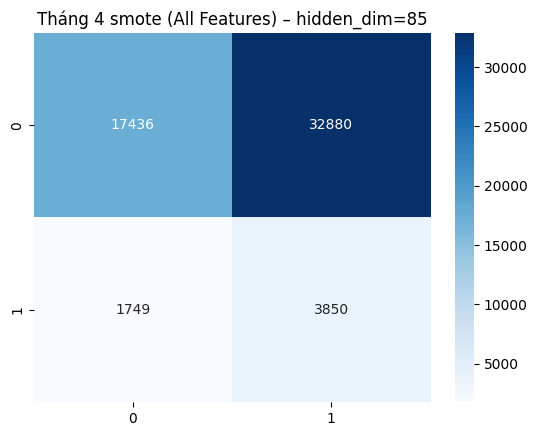


=== Dataset: Tháng 4 smote (Top Features) ===
 hidden_dim=10  → val loss = 0.693551


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=20  → val loss = 7.491948
 hidden_dim=50  → val loss = 0.694026
 hidden_dim=100 → val loss = 0.693199
 hidden_dim=150 → val loss = 0.694068


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=17  → val loss = 13.836483
 hidden_dim=25  → val loss = 7.478264
 hidden_dim=34  → val loss = 13.799297
 hidden_dim=50  → val loss = 0.693415
 hidden_dim=68  → val loss = 0.693604
 hidden_dim=85  → val loss = 0.693323
⇒ Best hidden_dim = 100, validation loss = 0.693199
Test classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     50316
           1       0.10      1.00      0.18      5599

    accuracy                           0.10     55915
   macro avg       0.05      0.50      0.09     55915
weighted avg       0.01      0.10      0.02     55915

Test confusion matrix:
 [[    0 50316]
 [    0  5599]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


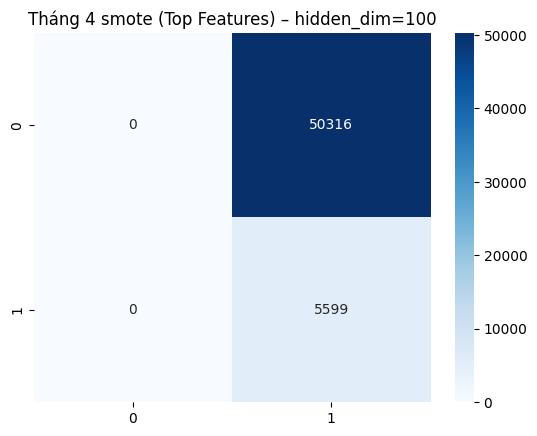

In [18]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

## SMOTE ENN

In [19]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [20]:
models_info = [
    ("Tháng 4 smote", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 smote (All Features) ===


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=10  → val loss = 6.906222
 hidden_dim=20  → val loss = 6.906222
 hidden_dim=50  → val loss = 6.879160
 hidden_dim=100 → val loss = 0.694909
 hidden_dim=150 → val loss = 0.693864


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=17  → val loss = 6.895036


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=25  → val loss = 6.920655
 hidden_dim=34  → val loss = 0.693556
 hidden_dim=50  → val loss = 0.693350


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=68  → val loss = 20.759439
 hidden_dim=85  → val loss = 0.694596
⇒ Best hidden_dim = 50, validation loss = 0.693350
Test classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     50316
           1       0.26      0.19      0.22      5599

    accuracy                           0.87     55915
   macro avg       0.59      0.57      0.57     55915
weighted avg       0.85      0.87      0.86     55915

Test confusion matrix:
 [[47304  3012]
 [ 4525  1074]]


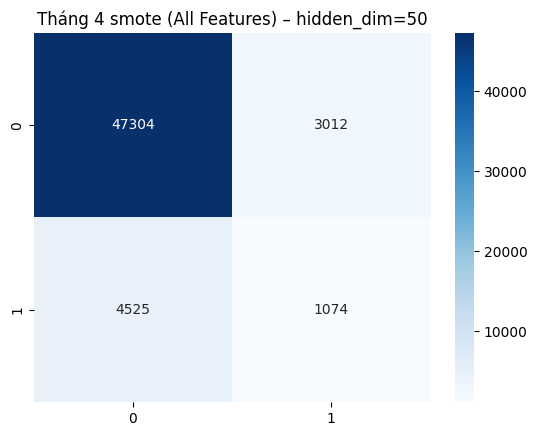


=== Dataset: Tháng 4 smote (Top Features) ===


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=10  → val loss = 21.026467
 hidden_dim=20  → val loss = 0.693514


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=50  → val loss = 6.571735
 hidden_dim=100 → val loss = 0.693850
 hidden_dim=150 → val loss = 0.694343
 hidden_dim=17  → val loss = 0.693486


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=25  → val loss = 6.594468
 hidden_dim=34  → val loss = 1.768542
 hidden_dim=50  → val loss = 6.601684
 hidden_dim=68  → val loss = 6.613591
 hidden_dim=85  → val loss = 0.693799
⇒ Best hidden_dim = 17, validation loss = 0.693486
Test classification report:
              precision    recall  f1-score   support

           0       0.70      0.15      0.25     50316
           1       0.05      0.41      0.09      5599

    accuracy                           0.18     55915
   macro avg       0.38      0.28      0.17     55915
weighted avg       0.63      0.18      0.24     55915

Test confusion matrix:
 [[ 7702 42614]
 [ 3308  2291]]


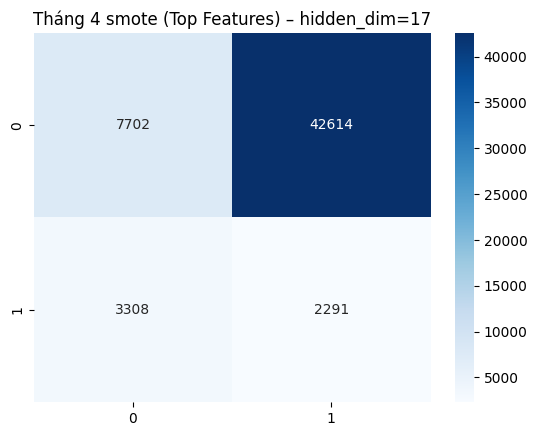

In [21]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)